In [1]:
import os
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
import logging
logging.getLogger().setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

In [3]:
train_df = pd.read_csv("train_10000.txt", header=None)
test_df = pd.read_csv("val_10000.txt", header=None)
val_df = pd.read_csv("test_10000.txt", header=None)

train_df.columns = val_df.columns = test_df.columns = ["label", "url"]
print(len(train_df), len(test_df), len(val_df))

49850 2624 9141


In [4]:
# build own tokenizer and vocab
from utils import get_word_vocab, get_words
x, word_reverse_dict = get_word_vocab(train_df.url.values, 200)
word_dict = {word_reverse_dict[key]:key for key in word_reverse_dict}
word_x = get_words(x, word_reverse_dict, 1, train_df.url.values)
def tokenizer(x):
    return get_words([x], word_reverse_dict, 1, train_df.url.values)[0]

Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Finished build vocabulary and mapping to x in 2.5685558319091797
Size of word vocabulary: 70650


In [5]:
# word_x -> list = tokenized url data
len(word_x)

49850

# load data

In [6]:
from utils import *

ngram_dict = pickle.load(open("runs/10000/subwords_dict.p", "rb")) 
print("Size of subword vocabulary (train): {}".format(len(ngram_dict)))
word_dict = pickle.load(open("runs/10000/words_dict.p", "rb"))
print("size of word vocabulary (train): {}".format(len(word_dict)))
chars_dict = pickle.load(open("runs/10000/chars_dict.p", "rb"))

# train
urls_train, labels_train = read_data("train_10000.txt")
x, word_reverse_dict = get_word_vocab(urls_train, 200) 
word_x_train = get_words(x, word_reverse_dict, 1, urls_train)
ngramed_id_x_train, worded_id_x_train = ngram_id_x_from_dict(word_x_train, 20, ngram_dict, word_dict) 
chared_id_x_train = char_id_x(urls_train, chars_dict, 200)
print("Number of training urls: {}".format(len(labels_train)))


# test
urls, labels = read_data("val_10000.txt")
x, word_reverse_dict = get_word_vocab(urls, 200) 
word_x = get_words(x, word_reverse_dict, 1, urls) 
ngramed_id_x, worded_id_x = ngram_id_x_from_dict(word_x, 20, ngram_dict, word_dict) 
chared_id_x = char_id_x(urls, chars_dict, 200)
print("Number of testing urls: {}".format(len(labels)))

Size of subword vocabulary (train): 131
size of word vocabulary (train): 16090
Finished build vocabulary and mapping to x in 3.3044486045837402
Size of word vocabulary: 70650
Index of <UNKNOWN> word: 15977
Processing url #0
Number of training urls: 49850
Finished build vocabulary and mapping to x in 0.15797734260559082
Size of word vocabulary: 7513
Index of <UNKNOWN> word: 15977
Processing url #0
Number of testing urls: 2624


# word

In [7]:
df_tmp = train_df.copy()
df_tmp['tokenized_list'] = word_x_train
word_mal_ratio = dict()

for word in tqdm(word_dict):
    df_tmp['exist'] = df_tmp['tokenized_list'].apply(lambda x:word in x)
    cnt = len(df_tmp.query('exist == True & label == 0'))
    word_mal_ratio[word] = cnt / df_tmp.exist.sum()

100%|██████████| 16090/16090 [11:19<00:00, 23.69it/s]


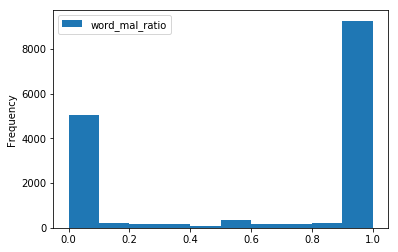

In [8]:
tmp = [word_mal_ratio[i] for i in word_mal_ratio]
tmp = pd.DataFrame({'word_mal_ratio':tmp, 'word':[i for i in word_mal_ratio]})
tmp.plot(kind='hist')

In [9]:
tmp.to_csv('word_mal_ratio.csv', index=False)

In [10]:
word_need_eliminate = set()
for word in tqdm(word_mal_ratio):
    ratio = word_mal_ratio[word]
    if ratio > 0.7 or ratio < 0.3:
        word_need_eliminate.add(word)

100%|██████████| 16090/16090 [00:00<00:00, 606749.78it/s]


In [11]:
len(word_need_eliminate), len(word_mal_ratio)

(15034, 16090)

In [12]:
word_dict['<UNKNOWN>']

15977

In [17]:
word_dict['http']

13777

In [13]:
char_reverse_dict = {chars_dict[key]:key for key in chars_dict}
word_reverse_dict = {word_dict[key]:key for key in word_dict}

In [14]:
unbias_worded_id_x = worded_id_x.copy()
unbias_worded_id_x_train = worded_id_x_train.copy()

for e, token_list in tqdm(enumerate(unbias_worded_id_x)):
    tmp = []
    for tokenId in token_list:
        token = word_reverse_dict[tokenId]
        if token in word_need_eliminate:
            tmp.append('<UNKNOWN>')
        else:
            tmp.append(token)
    unbias_worded_id_x[e] = tmp
    
for e, token_list in tqdm(enumerate(unbias_worded_id_x_train)):
    tmp = []
    for tokenId in token_list:
        token = word_reverse_dict[tokenId]
        if token in word_need_eliminate:
            tmp.append('<UNKNOWN>')
        else:
            tmp.append(token)
    unbias_worded_id_x_train[e] = tmp

2624it [00:00, 77027.03it/s]
49850it [00:00, 51137.69it/s]


In [18]:
for i, ii in zip(unbias_worded_id_x_train[:5], worded_id_x_train[:5]):
    print([j for j in i])
    print([word_reverse_dict[j] for j in ii])
    print()

['http', ':', '/', '/', '<UNKNOWN>', '.', '<UNKNOWN>', '.', '<UNKNOWN>', '/', '/', '<UNKNOWN>', '/', '<UNKNOWN>', '/', '<UNKNOWN>', '/', '<UNKNOWN>', '.', 'html']
['http', ':', '/', '/', 'samapi', '.', 'co', '.', 'th', '/', '/', 'php', '/', 'cache', '/', 'AOLUPDATE', '/', 'aol', '.', 'html']

['<UNKNOWN>', ':', '/', '/', '<UNKNOWN>', '.', 'com', '/', 'Go']
['https', ':', '/', '/', '<UNKNOWN>', '.', 'com', '/', 'Go']

['<UNKNOWN>', ':', '/', '/', '<UNKNOWN>', '.', '<UNKNOWN>', '.', '<UNKNOWN>', '/', '<UNKNOWN>', '/', '<UNKNOWN>', '.', '<UNKNOWN>', '/', '<UNKNOWN>', '/', '<UNKNOWN>', '/', '<UNKNOWN>', '/', '<UNKNOWN>', '/', '<UNKNOWN>', '.', '<UNKNOWN>']
['https', ':', '/', '/', 'www', '.', '<UNKNOWN>', '.', 'it', '/', 'mambots', '/', 'paypal', '.', 'fr', '/', 'us', '/', 'cgi-bin', '/', 'webscr', '/', '_login', '/', 'index', '.', 'php']

['http', ':', '/', '/', '<UNKNOWN>', '.', '<UNKNOWN>', '.', 'com', '/', '<UNKNOWN>', '?']
['http', ':', '/', '/', '153284594738391', '.', 'statictab', '

In [19]:
with open("unbias_worded_id_x_train.pkl", "wb") as f:
    pickle.dump(unbias_worded_id_x_train, f)

with open("unbias_worded_id_x.pkl", "wb") as f:
    pickle.dump(unbias_worded_id_x, f)

In [61]:
# url withour bias token -> very few
tmp = word_need_eliminate-set(['https'])
df_tmp['drop'] = df_tmp['tokenized_list'].apply(lambda x: len(set(x) & tmp)>0)
len(df_tmp[df_tmp['drop'] != True]), len(df_tmp)

(658, 49850)

# char

In [20]:
df_tmp2 = train_df.copy()
df_tmp2['tokenized_list'] = df_tmp2.url.apply(lambda x:list(x))
char_mal_ratio = dict()

for word in tqdm(chars_dict):
    df_tmp2['exist'] = df_tmp2['tokenized_list'].apply(lambda x:word in x)
    cnt = len(df_tmp2.query('exist == True & label == 0'))
    char_mal_ratio[word] = cnt / df_tmp2.exist.sum()

100%|██████████| 131/131 [00:15<00:00,  8.29it/s]


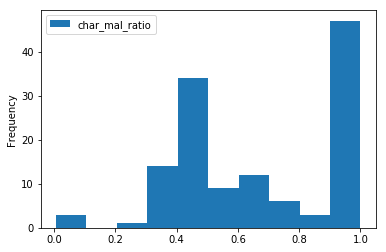

In [21]:
tmp2 = [char_mal_ratio[i] for i in char_mal_ratio]
tmp2 = pd.DataFrame({'char_mal_ratio':tmp2, 'char':[i for i in char_mal_ratio]})
tmp2.plot(kind='hist')

In [22]:
tmp2.to_csv('char_mal_ratio.csv', index=False)

In [23]:
char_need_eliminate = set()
for char in tqdm(char_mal_ratio):
    ratio = char_mal_ratio[char]
    if ratio > 0.7 or ratio < 0.3:
        char_need_eliminate.add(char)

100%|██████████| 131/131 [00:00<00:00, 216405.60it/s]


In [24]:
len(char_need_eliminate), len(char_mal_ratio)

(60, 131)

In [25]:
unbias_chared_id_x = chared_id_x.copy()
unbias_chared_id_x_train = chared_id_x_train.copy()

for e, token_list in tqdm(enumerate(unbias_chared_id_x)):
    tmp = []
    for tokenId in token_list:
        token = char_reverse_dict[tokenId]
        if token in word_need_eliminate:
            tmp.append('<UNKNOWN>')
        else:
            tmp.append(token)
    unbias_chared_id_x[e] = tmp
    
for e, token_list in tqdm(enumerate(unbias_chared_id_x_train)):
    tmp = []
    for tokenId in token_list:
        token = char_reverse_dict[tokenId]
        if token in word_need_eliminate:
            tmp.append('<UNKNOWN>')
        else:
            tmp.append(token)
    unbias_chared_id_x_train[e] = tmp

2624it [00:00, 27106.34it/s]
49850it [00:01, 27150.69it/s]


In [26]:
with open("unbias_chared_id_x_train.pkl", "wb") as f:
    pickle.dump(unbias_chared_id_x_train, f)

with open("unbias_chared_id_x.pkl", "wb") as f:
    pickle.dump(unbias_chared_id_x, f)

In [27]:
with open("word_mal_ratio.pkl", "wb") as f:
    pickle.dump(word_mal_ratio, f)

with open("char_mal_ratio.pkl", "wb") as f:
    pickle.dump(char_mal_ratio, f)

### stored pickle and csv files

#### csv
* train_bias.csv     : bias of most critical word in explanation train set
* test_bias.csv      : bias of most critical word in explanation test set
* char_mal_ratio.csv : ratio of each char
* word_mal_ratio.csv : ratio of each word

#### pickle
* unbias_worded_id_x_train.pkl  : unbias worded_id_x_train
* unbias_worded_id_x.pkl        : unbias worded_id_x
* unbias_chared_id_x_train.pkl  : unbias chared_id_x_train
* unbias_chared_id_x.pkl        : unbias chared_id_x
* char_mal_ratio
* word_mal_ratio

## Detail of each variable

* ngram_dict = chars 2 idx -> dict
* word_dict = word 2 idx -> dict
* char_dict = chars 2 idx -> dict (same as ngram_dict)


1. x, reverse_dict = get_word_vocab(urls, FLAGS["data.max_len_words"])
    Use tflearn.VocabularyProcessor
    x = tokenized and transformed url -> ndarray
    word_reverse_dict -> dict
   
   
2. word_x = get_words(x, word_reverse_dict, FLAGS["data.delimit_mode"], urls)
    word_x = tokenized url -> ndarray
    
3. 
    * train

    ngramed_id_x, ngrams_dict, worded_id_x, words_dict = ngram_id_x(word_x, FLAGS["data.max_len_subwords"], high_freq_words)

    * test
    
    ngramed_id_x_train, worded_id_x_train = ngram_id_x_from_dict(word_x_train, 20, ngram_dict, word_dict) 
    
    
    ngramed_x_id = transformed char-level-word url -> list[list[list]]
    worded_x_id = transformed word url -> list[list]
    
    
4. chared_id_x = char_id_x
    chared_id_x = transformed char url -> list[list]

* word_dict is obtained from ngram_id_x
* x, word_reverse_dict -> only help tokenize